# This notebook is to show some statistics of the cleaned data

In [2]:
# define the path of the data and project
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

# 1. Import the cleaned data

In [3]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) object ...
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [3]:
ds_cleaned_750.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) object ...
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...>

In [4]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_250=xr.open_dataset(f"{data_path}/ds_cleaned_250.nc")
ds_cleaned_250

<xarray.Dataset>
Dimensions:           (nprof: 67040, pressure: 48)
Coordinates:
    profiler          (nprof) object ...
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -240.0 -245.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

# 2. Define functions that plot the data

In [16]:

# function to plot the heatmap of the profiles distribution
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_heatmap(ds_cleaned, bin_max=None):
    '''
    ds_cleaned: A dataset containing cleaned data.
    bin_max (optional): The maximum bin value for the heatmap. If not provided, it is calculated as the maximum value of the histogram.
    '''

    # Define the map bounds and resolution
    lon_min, lon_max = -180, 180
    lat_min, lat_max = 70, 90
    latlon_step = 5
    resolution = 'l'  # l for low resolution, h for high resolution

    # Define bin edges for longitude, latitude, and pressure
    lon_bins = np.arange(lon_min, lon_max+1, latlon_step)
    lat_bins = np.arange(lat_min, lat_max+1, latlon_step)

    # Use the number of profiles in each bin as the height
    H, xedges, yedges = np.histogram2d(ds_cleaned.lon, ds_cleaned.lat, bins=[lon_bins, lat_bins])

    # Set up the figure and the Basemap instance
    fig = plt.figure(figsize=(8,8),dpi=300)
    m = Basemap(projection='npstere', boundinglat=lat_min, lon_0=0, resolution=resolution)

    m.drawparallels(np.arange(lat_min, lat_max+1, 5), labels=[], linewidth=0.1)
    m.drawmeridians(np.arange(lon_min, lon_max+1, 5), labels=[], linewidth=0.1)

    # Create the X and Y grids for the histogram
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    new_col = np.arange(lat_min, lat_max, latlon_step)
    Y = np.concatenate((Y, new_col[:, np.newaxis]), axis=1)

    new_col = lon_max*np.ones(len(lat_bins)-1)
    X = np.concatenate((X, new_col[:, np.newaxis]), axis=1)

    new_row = X[-1]
    X=np.vstack([X,new_row])

    new_row = lat_max*np.ones(np.shape(Y)[1])
    Y=np.vstack([Y,new_row])

    # Create the colored grid using pcolormesh
    cmap = plt.get_cmap('Wistia').copy()
    cmap.set_under(color='white', alpha=1.0)
    cmap.set_over(color='white', alpha=1.0)

    if bin_max is None:
        bin_max = H.max()
    

    m.pcolormesh(X, Y, H.T, cmap=cmap, vmin=1, vmax=bin_max, latlon=True)

    m.drawcoastlines()
    m.fillcontinents(color='grey',lake_color='lightblue')

    # Add a colorbar
    cbar = m.colorbar(location='bottom', pad="5%")
    cbar.set_label('Number of profiles')

    # Set the axis labels and title
    plt.xticks([])
    plt.yticks([])
    plt.title('Profiles distribution')

    # Show the plot
    plt.show()
    print(f'bin max={bin_max}')


##########################################################################################
import random
import matplotlib.pyplot as plt

def profiles_overview(ds_cleaned, ratio=0.1):
    '''
    ds_cleaned: A dataset containing cleaned data.
    ratio (optional): The ratio of temperature and salinity profiles to be plotted. Defaults to 0.1 (10%).
    '''

    variables = ['temperature', 'salinity', 'dissolved_oxygen']
    titles = ['Temperature (°C)', 'Salinity', 'Oxygen']
    colors = ['tomato', 'tomato', 'tomato']

    n_profiles = int(ds_cleaned.dims['nprof'] * ratio)
    profile_indices = random.sample(range(ds_cleaned.dims['nprof']), n_profiles)

    fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(16, 6), dpi=300)

    for i, (variable, title, color) in enumerate(zip(variables, titles, colors)):
        median = ds_cleaned[variable].quantile(q=0.5, dim='nprof')
        lower = ds_cleaned[variable].quantile(q=0.05, dim='nprof')
        upper = ds_cleaned[variable].quantile(q=0.95, dim='nprof')

        for profile_index in profile_indices:
            axes[i].plot(ds_cleaned[variable][profile_index].values, ds_cleaned['pressure'].values, color='lightgrey', linewidth=0.5)

        axes[i].plot(median, ds_cleaned['pressure'], color=color, label='Median')
        axes[i].plot(lower, ds_cleaned['pressure'], color='blue', label='5th Percentile')
        axes[i].plot(upper, ds_cleaned['pressure'], color='blue', label='95th Percentile')

        axes[i].set_xlabel(title)
        axes[i].set_ylabel('Pressure (dbar)')
        axes[i].set_ylim(np.min(ds_cleaned['pressure']), np.max(ds_cleaned['pressure']))
        axes[i].legend(loc='lower right')

    fig.suptitle(f'Profiles Overview with {int(ratio*100)}% of Temperature, Salinity, and Oxygen Profiles', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()



##########################################################################################
import random
import matplotlib.pyplot as plt

def profiles_overview_without_oxy(ds_cleaned, ratio=0.1):
    '''
    ds_cleaned: A dataset containing cleaned data.
    ratio (optional): The ratio of temperature and salinity profiles to be plotted. Defaults to 0.1 (10%).
    '''

    median_temperature = ds_cleaned['temperature'].quantile(q=0.5, dim='nprof')
    lower_temperature = ds_cleaned['temperature'].quantile(q=0.05, dim='nprof')
    upper_temperature = ds_cleaned['temperature'].quantile(q=0.95, dim='nprof')

    median_salinity = ds_cleaned['salinity'].quantile(q=0.5, dim='nprof')
    lower_salinity = ds_cleaned['salinity'].quantile(q=0.05, dim='nprof')
    upper_salinity = ds_cleaned['salinity'].quantile(q=0.95, dim='nprof')

    n_profiles = int(ds_cleaned.dims['nprof'] * ratio)
    profile_indices = random.sample(range(ds_cleaned.dims['nprof']), n_profiles)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), dpi=300)

    # plot temperature profiles
    for i in profile_indices:
        ax1.plot(ds_cleaned['temperature'][i].values, ds_cleaned['pressure'].values, color='lightgrey', linewidth=0.5)
    ax1.plot(median_temperature, ds_cleaned['pressure'], color='tomato', label='Median')
    ax1.plot(lower_temperature, ds_cleaned['pressure'], color='blue', label='5th Percentile')
    ax1.plot(upper_temperature, ds_cleaned['pressure'], color='blue', label='95th Percentile')
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Pressure (dbar)')
    ax1.set_ylim(np.min(ds_cleaned['pressure']), np.max(ds_cleaned['pressure']))
    ax1.legend(loc='lower right')

    # plot salinity profiles
    for i in profile_indices:
        ax2.plot(ds_cleaned['salinity'][i].values, ds_cleaned['pressure'].values, color='lightgrey', linewidth=0.5)
    ax2.plot(median_salinity, ds_cleaned['pressure'], color='tomato', label='Median')
    ax2.plot(lower_salinity, ds_cleaned['pressure'], color='blue', label='5th Percentile')
    ax2.plot(upper_salinity, ds_cleaned['pressure'], color='blue', label='95th Percentile')
    ax2.set_xlabel('Salinity')
    ax2.set_ylim(np.min(ds_cleaned['pressure']), np.max(ds_cleaned['pressure']))
    ax2.legend(loc='lower left')

    fig.suptitle(f'Median Profile with {int(ratio*100)}% of Temperature and Salinity Profiles', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()



# ##########################################################################################
# def plot_average_oxy_profile(ds,ratio=0.1):
#     '''
#     ds: A dataset containing cleaned data.
#     '''
#     median_oxygen = ds['dissolved_oxygen'].quantile(q=0.5, dim='nprof')
#     lower_oxygen = ds['dissolved_oxygen'].quantile(q=0.05, dim='nprof')
#     upper_oxygen = ds['dissolved_oxygen'].quantile(q=0.95, dim='nprof')

#     fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

#     n_profiles = int(ds.dims['nprof'] * ratio)
#     profile_indices = random.sample(range(ds.dims['nprof']), n_profiles)


#     for i in profile_indices:
#         ax.plot(ds['dissolved_oxygen'][i].values, ds['pressure'].values, color='lightgrey', linewidth=0.5)

    
#     # plot oxygen profiles
#     ax.plot(median_oxygen, ds['pressure'], color='tomato', label='Median')
#     ax.plot(lower_oxygen, ds['pressure'], color='blue', label='5th Percentile')
#     ax.plot(upper_oxygen, ds['pressure'], color='blue', label='95th Percentile')

#     ax.set_xlabel('Oxygen')
#     ax.set_ylabel('Pressure (dbar)')
#     ax.set_ylim(np.min(ds['pressure']), np.max(ds['pressure']))
#     ax.legend(loc='lower right')

#     fig.suptitle(f'Median Profile of Oxygen', fontsize=16, y=1.05)
#     # plt.tight_layout()
#     plt.show()


##########################################################################################
import matplotlib.pyplot as plt
import numpy as np

def plot_temporal_dis(ds_cleaned):
    '''
    ds_cleaned: A dataset containing cleaned data.
    '''
    # get the year and month from each date ds_cleaned.date 
    years = ds_cleaned.date.dt.year.values
    months = ds_cleaned.date.dt.month.values
    fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

    # Histogram of the number of profiles per month
    bins_month = np.arange(1, 14)  # set bin edges
    ax[0].hist(months, bins=bins_month, color='cornflowerblue', edgecolor='black', linewidth=1)
    ax[0].set_xlabel('Month')
    ax[0].set_ylabel('Number of profiles')
    # ax[0].set_title('Number of profiles per month')
    ax[0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,1])

    # Histogram of the number of profiles per year
    bins_year = np.arange(np.min(years), np.max(years)+1)  # set bin edges 
    ax[1].hist(years, bins=bins_year, color='cornflowerblue', edgecolor='black', linewidth=1)
    ax[1].set_xlabel('Year')
    # ax[1].set_ylabel('Number of profiles')
    # ax[1].set_title('Number of profiles per year')
    ax[1].set_xticks(np.arange(np.min(years), np.max(years) + 1))
    ax[1].set_xticklabels(np.arange(np.min(years), np.max(years) + 1), rotation=90) # rotate xticklabels by 90 degrees

    plt.show()

##########################################################################################
# function that plot three histograms, the first is the month distribution, the second and third are the longtidue and latitude distribution
import matplotlib.pyplot as plt
import seaborn as sns


def plot_latlon_dis(ds):
    '''
    ds: A dataset containing cleaned data.
    '''
    months = ds.date.dt.month.values

    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
    fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
    sns.histplot(ds.lon, ax=ax[0])
    sns.histplot(ds.lat, ax=ax[1])
    # set the x and y label
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Number of profiles')
    ax[1].set_xlabel('Latitude')
    # turn off the ylabel
    ax[1].set_ylabel('')
    # ax[1].set_ylabel('Number of profiles')
    # set the title
    # ax[0].set_title('Longitude distribution')
    # ax[1].set_title('Latitude distribution')
    plt.show()

##########################################################################################

# function that plot the distribution of each month
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latlon_dis_by_month(ds):
    '''
    ds: A dataset containing cleaned data.
    '''
    
    # group the dataset by month
    ds_monthly = ds.groupby('date.month')
    
    # plot the latitude and longitude distribution of each month
    fig, ax = plt.subplots(12,2,figsize=(20,10*12),dpi=300)
    for i in range(12):
        sns.histplot(ds_monthly[i+1].lon,ax=ax[i,0])
        sns.histplot(ds_monthly[i+1].lat,ax=ax[i,1])
        ax[i,0].set_xlabel('Longitude')
        ax[i,0].set_ylabel('Count')
        ax[i,0].set_title(f'Month {i+1}')
        ax[i,1].set_xlabel('Latitude')
        ax[i,1].set_ylabel('Count')
        ax[i,1].set_title(f'Month {i+1}')
    plt.show()




# 3. Call functions to get statistics of the data

## 3.1. Plot the median of the Temperature, Salinity and dissolved oxygen as long as 10% randomly selected profiles

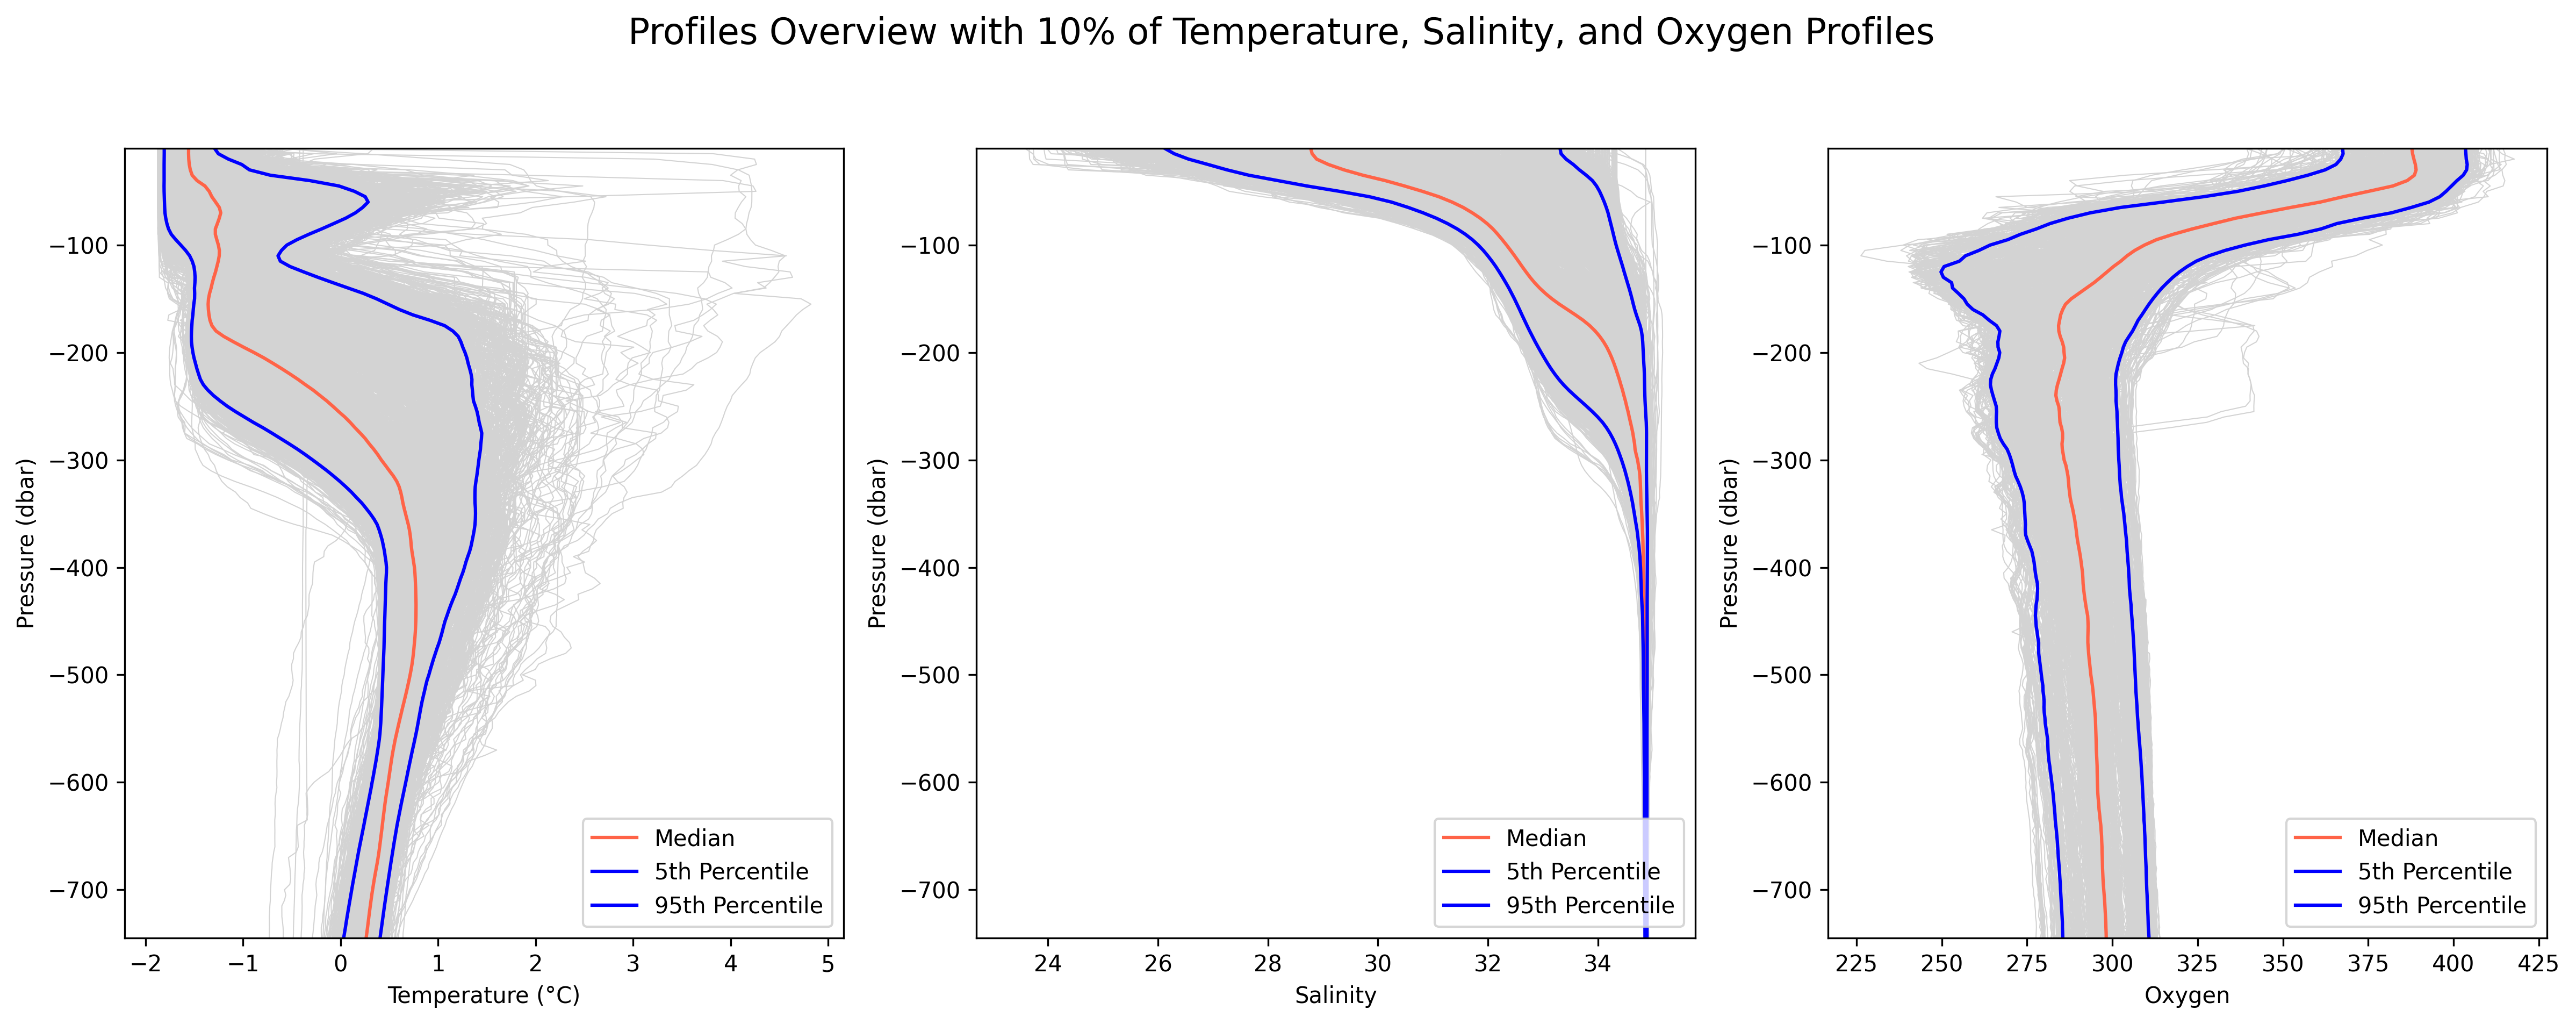

In [6]:
profiles_overview(ds_cleaned_750, ratio=0.1)

## 3.2 Plot the heatmap for the number of profiles in five by five digree latitude longitude bins and histograms for profiles

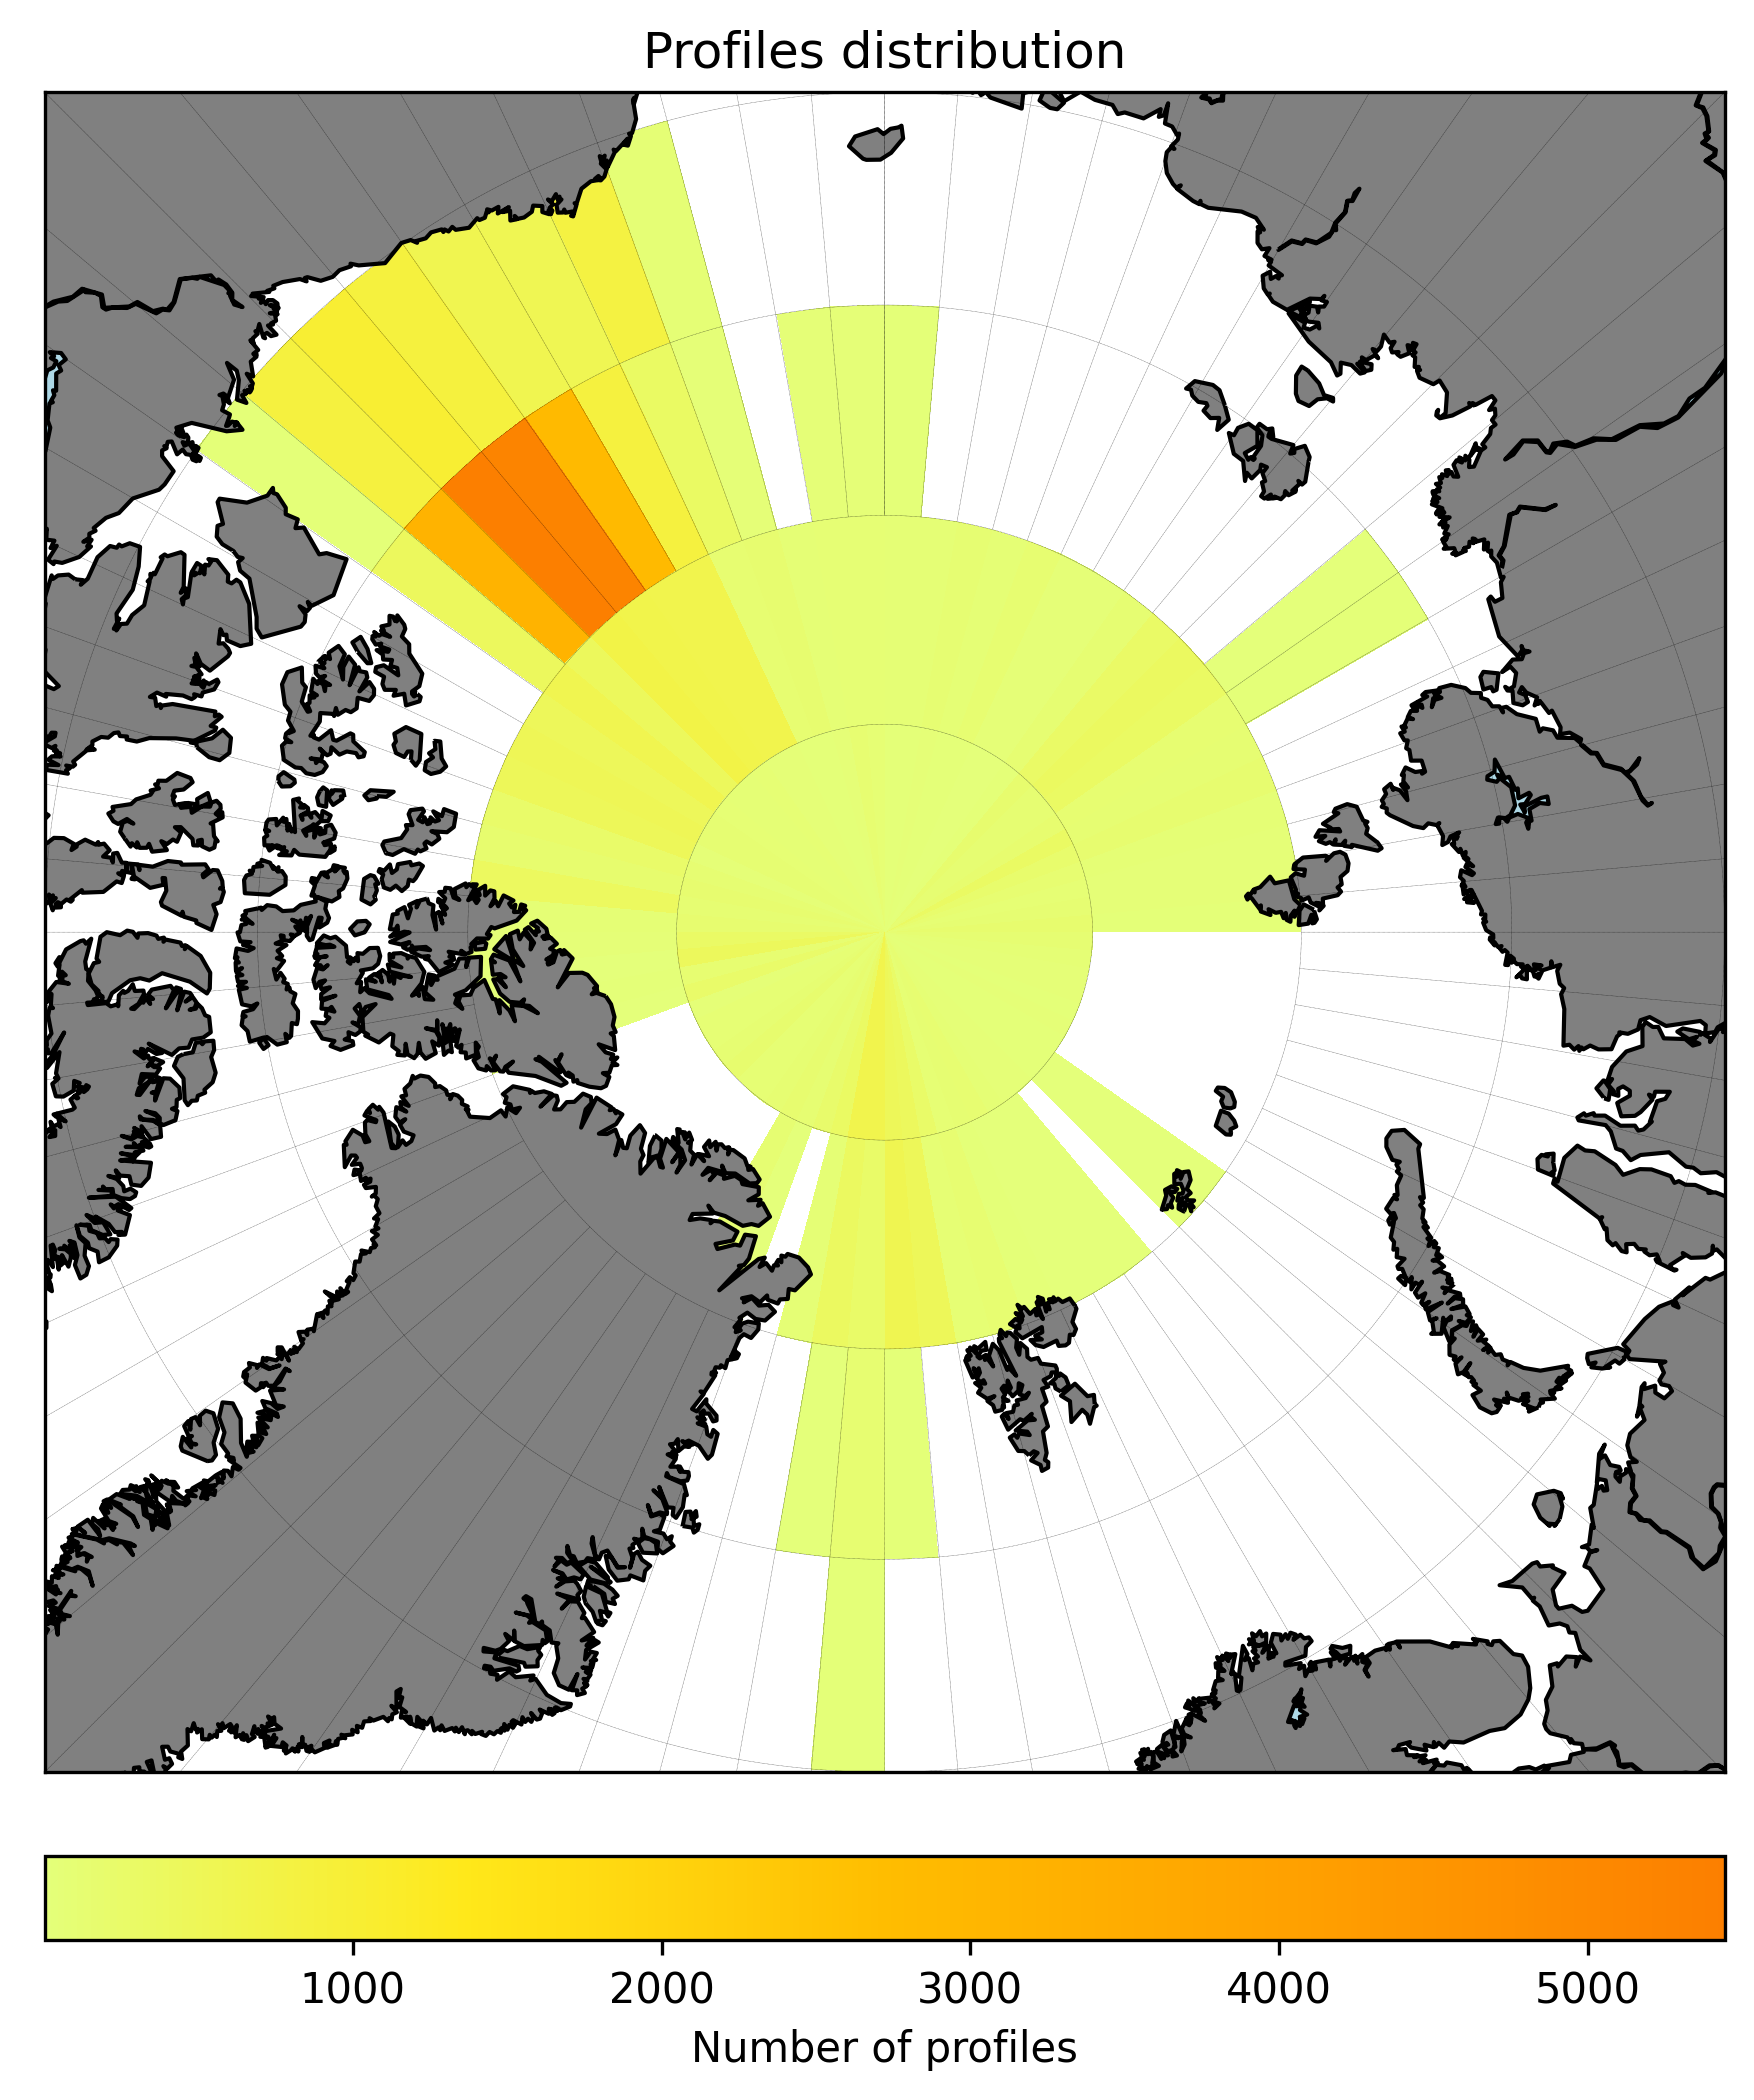

bin max=5444.0


In [9]:
plot_heatmap(ds_cleaned_750)


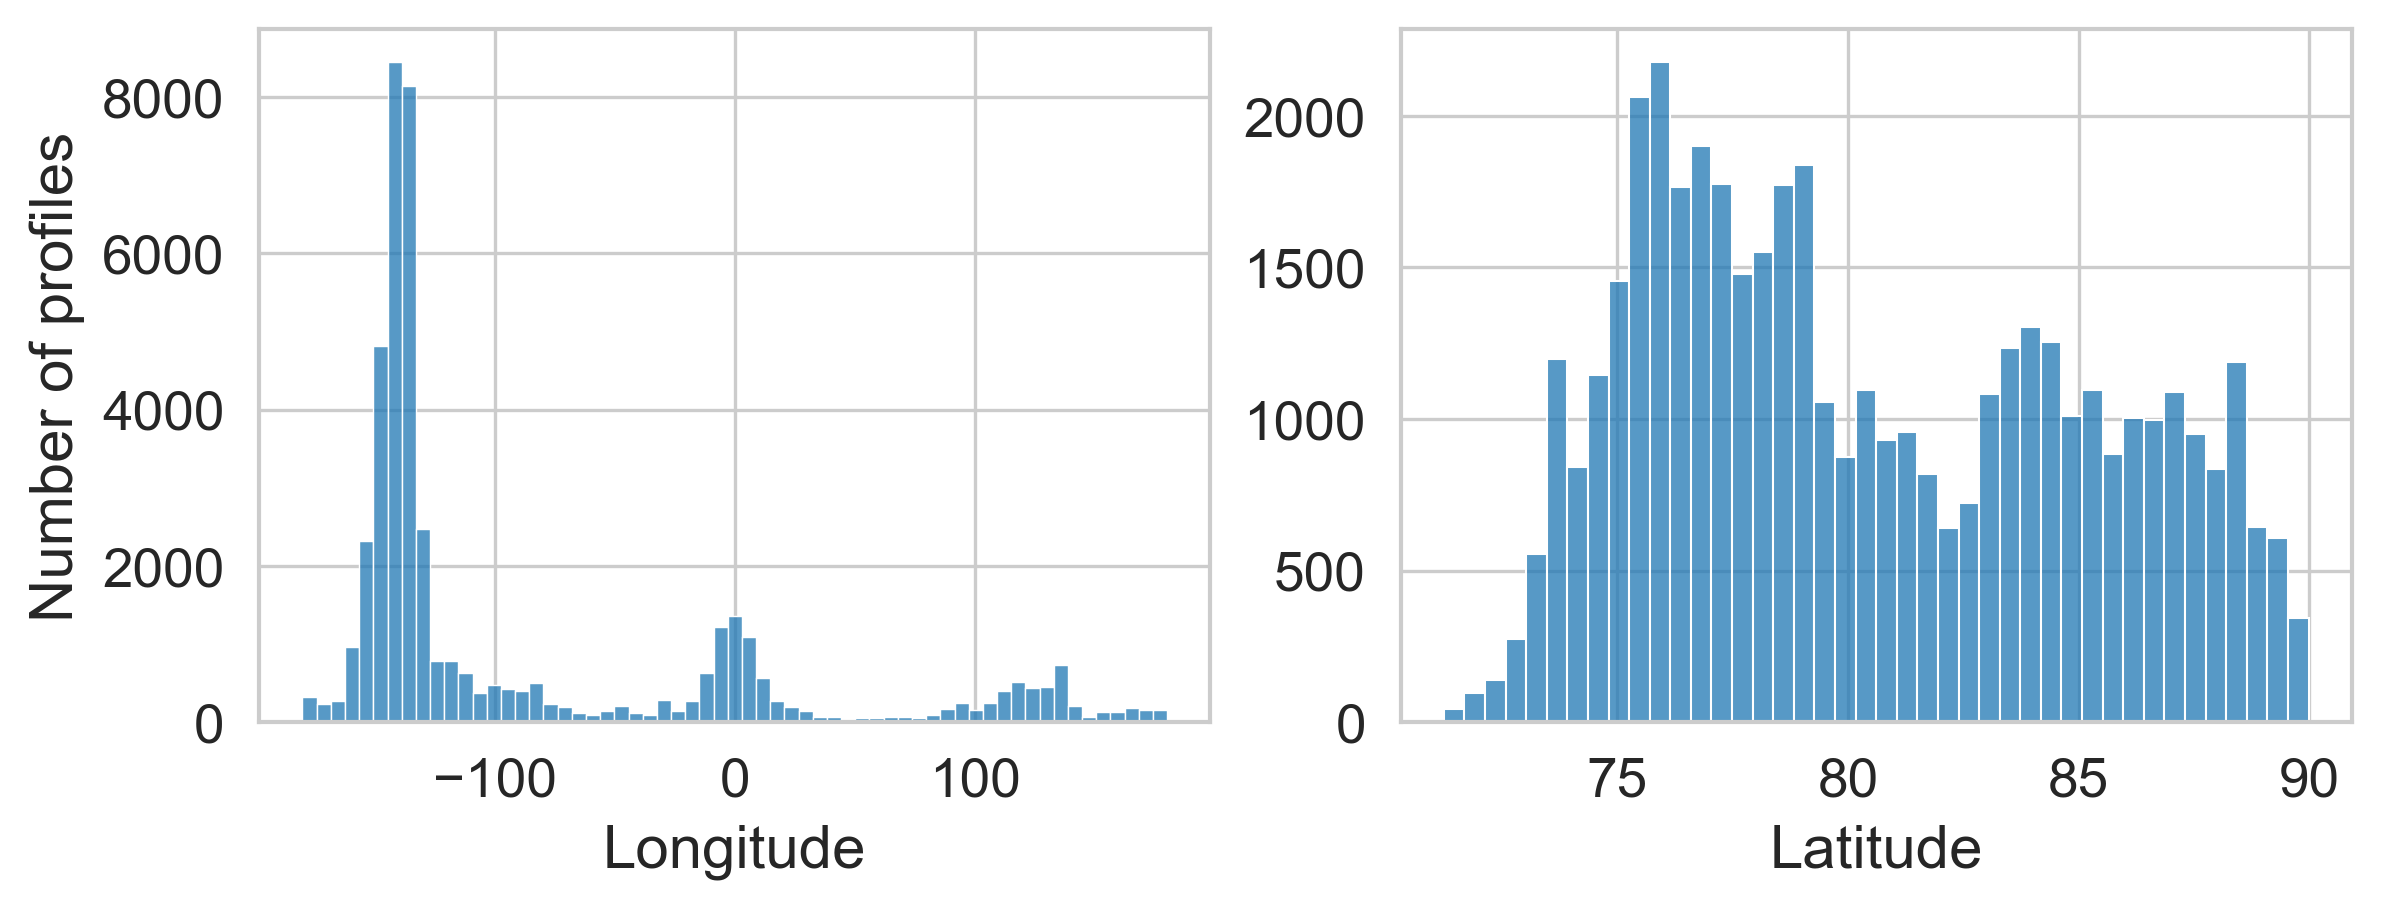

In [17]:
plot_latlon_dis(ds_cleaned_750)


## 3.3 Plot the temporal distribution of the data

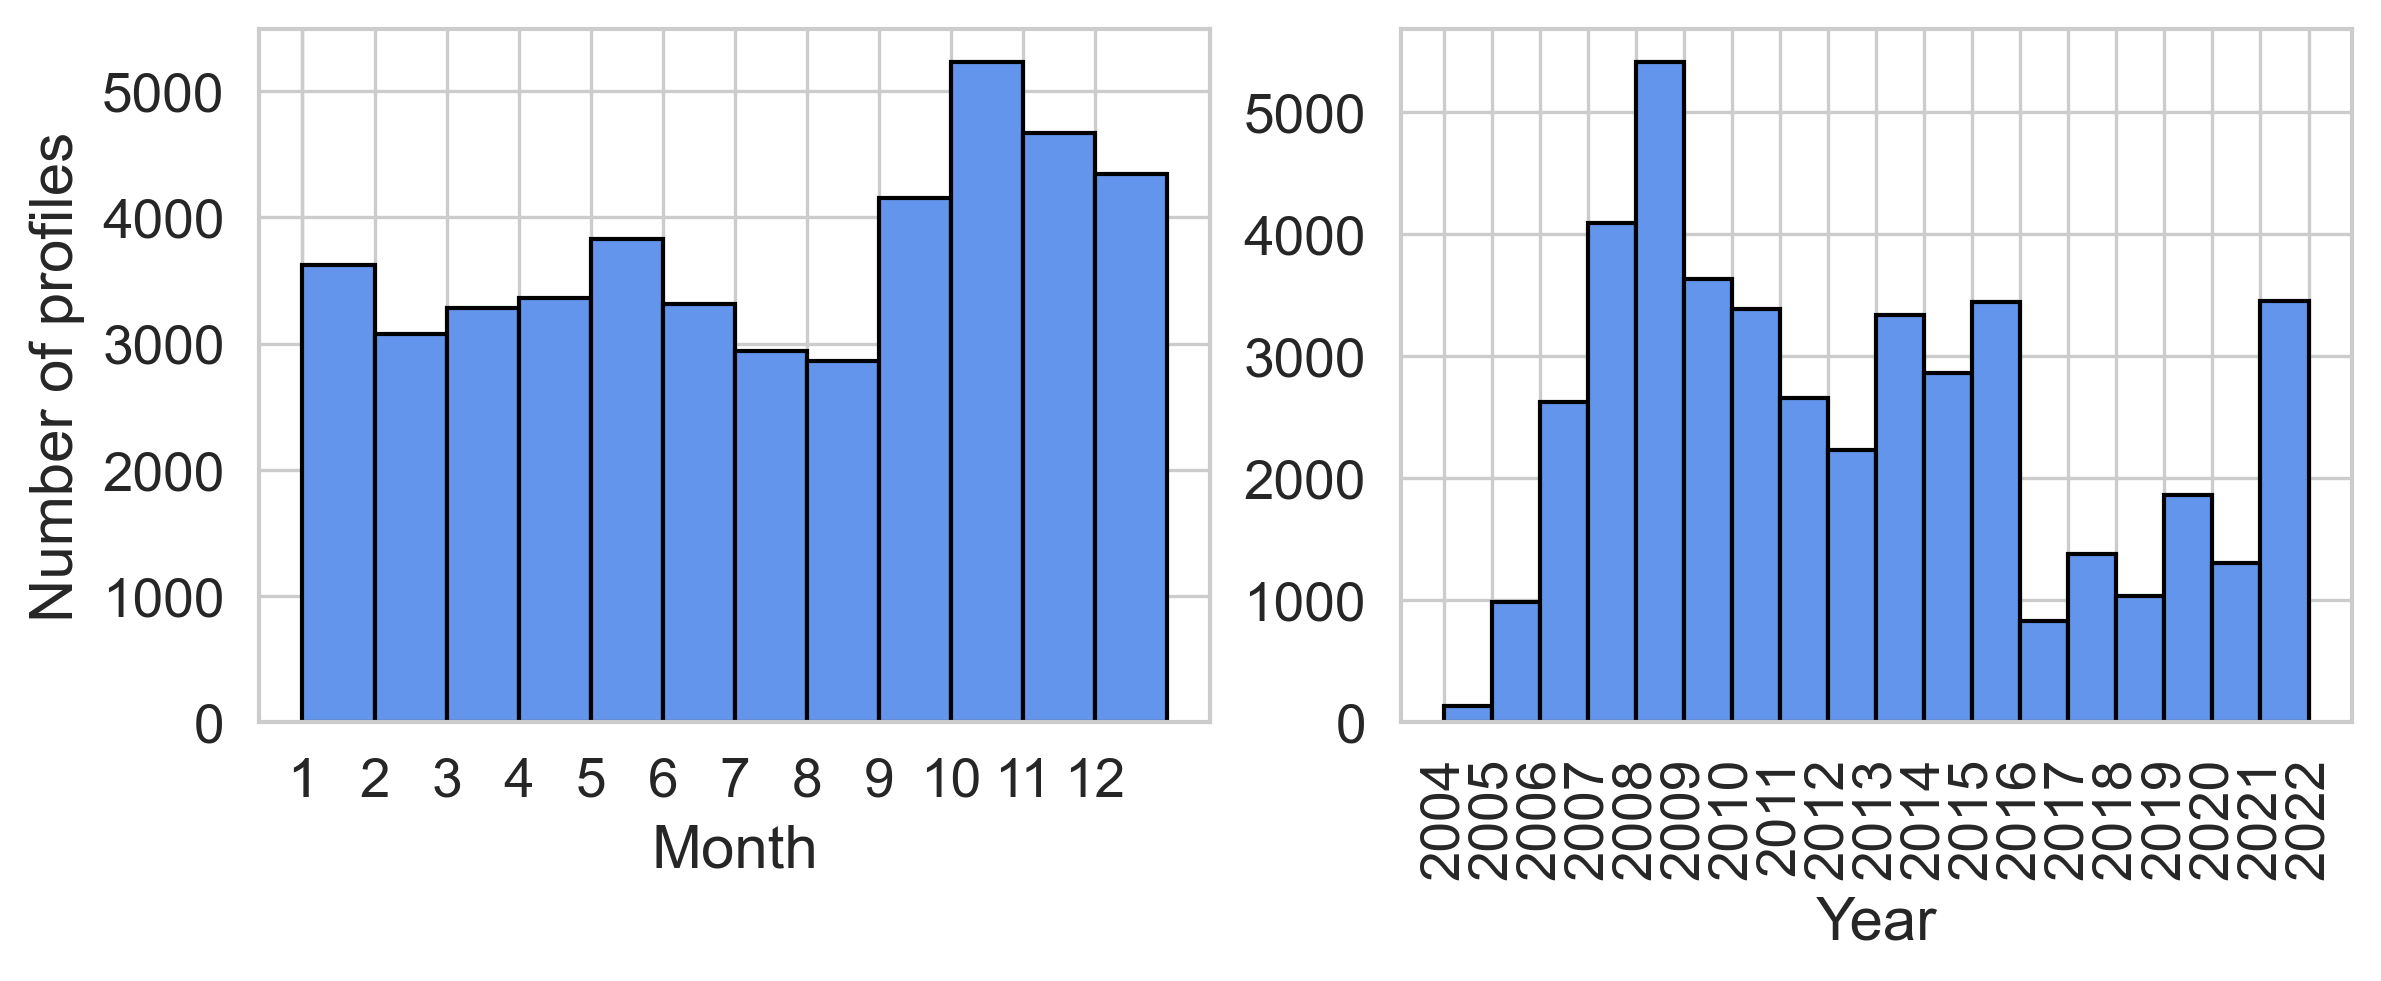

In [18]:
plot_temporal_dis(ds_cleaned_750)

## 3.4 Plot the latlon distribution of the data for each month to see if there is any bias between months

In [20]:
plot_latlon_dis_by_month(ds_cleaned_750)

